In [13]:
import osmnx as ox
# import osm2gmns as og
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from pyproj import CRS
import contextily as ctx
# from dotmotif import Motif, GrandIsoExecutor
from shapely import speedups
import numpy as np
import xml.etree.ElementTree as ET
import glob
import multiprocessing
import time

## Data preprocessing

### KowLong street graph from OSM

In [14]:
def load_from_osm(place_name="Kowloon, Hong Kong, China"):

    # Get the area of interest polygon
    place_polygon = ox.geocode_to_gdf(place_name)
    # Re-project the polygon back to WGS84, as required by osmnx
    place_polygon = place_polygon.to_crs(epsg=4326)
    # Retrieve the network
    graph = ox.graph_from_polygon(place_polygon["geometry"].values[0], network_type='drive', custom_filter='["highway"~"primary|secondary|trunk"]')

    # Project the data to UTM, since ox.consolidate_intersections need this CRS to compute disntance, WGS84 is not for distance computation
    graph_proj = ox.project_graph(graph, 'EPSG:32649')
    #
    graph_proj = ox.consolidate_intersections(graph_proj, tolerance=20)
    # re-project the graph back to WGS84 for visualization in longitude and latitude format
    graph_proj = ox.project_graph(graph_proj, "EPSG:4326")
    #
    graph_proj = graph_proj.to_undirected()
    # Get Edges and Nodes
    nodes_proj, edges_proj = ox.graph_to_gdfs(graph_proj, nodes=True, edges=True)
    # ox.save_graph_xml(graph, './data/kowlong.osm')
    return nodes_proj, edges_proj, place_polygon
    
nodes_proj, edges_proj, place_polygon = load_from_osm("Kowloon, Hong Kong, China")

### KowLong sensor points

In [15]:
def load_sensor_data(file_path = './dataset/traffic_speed_volume_occ_info.csv'):
    raw_sensors = pd.read_csv(file_path)
    raw_sensors_gpd = gpd.GeoDataFrame(raw_sensors, geometry=gpd.points_from_xy(raw_sensors.Longitude, raw_sensors.Latitude), crs = "EPSG:4326")
    # enable spatial query speed up
    speedups.enabled
    sensor_mask = raw_sensors_gpd.within(place_polygon.loc[0, 'geometry'])
    sensors_gpd = raw_sensors_gpd[sensor_mask]

    return sensors_gpd

sensors_gpd = load_sensor_data()

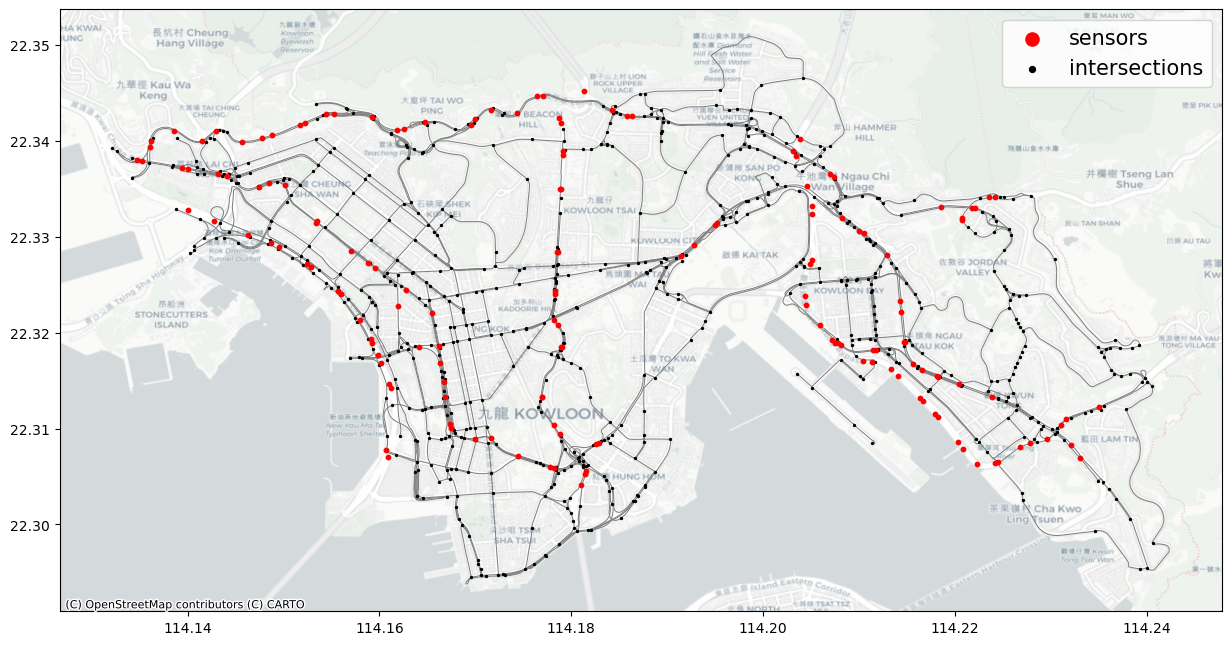

In [16]:
# plot the graph:
fig, ax = plt.subplots(figsize=(15,15))
# Plot edges and nodes
sensors_gpd.plot(ax=ax, markersize=10, color='red',label='sensors', zorder=3)
nodes_proj.plot(ax=ax, markersize=2, color='black', label='intersections',zorder=2)
edges_proj.plot(ax=ax, linewidth=0.75, color='gray', zorder=1)

ax.legend(markerscale=3, prop={'size': 15})
# minx, miny, maxx, maxy = place_polygon.bounds.values[0]
# ax.set_xlim(minx, maxx)
# ax.set_ylim(miny, maxy)
# Add the origin and destination nodes of the route
# ax = motif_nodes.plot(ax=ax, markersize=3, color='red')
# Add basemap

ctx.add_basemap(ax, crs=nodes_proj.crs, source=ctx.providers.CartoDB.Positron)
fig.savefig('./figs/sensor_street_kowlong.svg')

In [17]:
# print(road segment type))
def unique(list1):
    # intilize a null list
    unique_list = []

    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)

    return unique_list

unique(edges_proj.highway.values)

['primary',
 'primary_link',
 'secondary',
 ['primary', 'primary_link'],
 'secondary_link',
 ['secondary_link', 'primary_link'],
 'trunk_link',
 'trunk',
 ['trunk', 'trunk_link'],
 ['trunk_link', 'secondary'],
 ['primary', 'trunk_link'],
 ['primary', 'secondary'],
 ['secondary_link', 'secondary'],
 ['primary_link', 'secondary'],
 ['trunk', 'primary'],
 ['secondary_link', 'trunk_link'],
 ['secondary', 'trunk_link'],
 ['trunk', 'primary', 'trunk_link']]

### Concat sensor_gpd and street node gpd, and compute distance matrix

make sure CRS are identical

In [18]:
nodes_proj.crs == sensors_gpd.crs

True

Missing rate: #road_nodes / (#road_nodes + #sensors)

In [19]:
nodes_proj.shape[0] / (nodes_proj.shape[0] + sensors_gpd.shape[0])

0.8121353558926487

re-project from WGS84 to UTM for distance matrix computation

In [20]:
nodes_proj.to_crs(32649,inplace=True)
sensors_gpd.to_crs(32649,inplace=True)

Some detector id cannot match with thoes of speed data

In [21]:
sensors_gpd.AID_ID_Number = sensors_gpd.AID_ID_Number.str.replace(r'/', '')

In [22]:
sensors_gpd.reset_index(drop=True,inplace=True)
sensors_gpd.head(1)

,AID_ID_Number,District,Road_EN,Road_TC,Road_SC,Easting,Northing,Latitude,Longitude,Direction,Rotation,geometry
0,AID01111,Kowloon City,Hong Chong Road near The Hong Kong Polytechnic...,康莊道近香港理工大學 - 北行（1）,康庄道近香港理工大学 - 北行（1）,836693,818352,22.30412,114.180999,East,80,POINT (827761.392 2469944.950)


In [23]:
sensors_id_array = np.unique(sensors_gpd.AID_ID_Number)

concat the two geodataframes

In [24]:
def concat_gpd(nodes_proj, sensors_gpd):
    node_cat = nodes_proj[['geometry']].reset_index(drop=True)
    node_cat['type'] = 'intersection'
    sensor_cat = sensors_gpd[['geometry']].reset_index(drop=True)
    sensor_cat['type'] ='sensor'
    node_total = pd.concat([sensor_cat, node_cat]).reset_index(drop=True)
    node_total.head(3)
    
    return node_total

## Kowlong speed data preprocessing

Update sensors_id_array since we need an union of sensor_id in speed data and sensor location data

In [27]:
root_path = './HK_traffic_speed'
day_path = glob.glob(root_path+"./*")

In [28]:
import multi_data
def update_sensor_ls(path, sensors_id_array, sensors_gpd):
    params = [path, sensors_id_array, sensors_gpd, 1]
    speed_df=multi_data.load_speed_data(params)
    # also update sensors_gpd
    
    return np.intersect1d(np.unique(speed_df.detector_id), sensors_id_array)

sensors_id_array = update_sensor_ls(day_path[0], sensors_id_array, sensors_gpd)
sensors_gpd = sensors_gpd[sensors_gpd.AID_ID_Number.isin(sensors_id_array)]
sensors_gpd.reset_index(drop=True, inplace=True)

In [15]:
params = []
for i in range(len(day_path)):
    params.append([day_path[i], sensors_id_array, sensors_gpd, 0])
cores = multiprocessing.cpu_count() - 1
with multiprocessing.Pool(cores) as pool:
    nd_ls = pool.map(multi_data.load_speed_data, params, chunksize=1)
    pool.close()
    pool.join()

In [16]:
day_nslot_ls = [each.shape[0] for each in nd_ls]
day_nslot_ls_df = pd.DataFrame(day_nslot_ls)

In [17]:
# ndarray_1day = pd.DataFrame(np.round(ndarray_1day.astype(np.double),2))
# ndarray_1day.fillna(method="ffill",inplace=True)
df_total = pd.DataFrame(np.concatenate(nd_ls, axis=0))

In [ ]:
day_nslot_ls_df.to_csv('./dataset/kowlong_nslot_ls.csv',header=False, index=False)
df_total.to_csv('./dataset/kowlong_sensor_speed.csv',header=False, index=False)

Compute distance matrix

In [ ]:
node_total = concat_gpd(nodes_proj, sensors_gpd)
node_total.geometry.apply(lambda g: node_total.distance(g)).to_csv('./data/kowlong_distance.csv', header=False, index=False)

In [ ]:
node_total.geometry.apply(lambda g: node_total.distance(g)).index

Points in polyon, select the seosors within Kowlong

In [ ]:
executor = GrandIsoExecutor(graph=graph_proj)

round = Motif("""
A -> B
B -> C
C -> D
D -> E
E -> A
""",exclude_automorphisms=True)

triangle = Motif("""
A -> B
B -> C
C -> A
""",ignore_direction=True)

square = Motif("""
A -> B
B -> C
C -> D
D -> A
""", ignore_direction=True)

strange = Motif("""
A -> B
C -> B
D -> B
E -> B
""", ignore_direction=True)

results = executor.find(triangle)

In [ ]:
import pandas as pd
results_df = pd.DataFrame(results)
motif_nodes = [nodes_proj.loc[each] for each in results_df.values.flatten()]


In [ ]:
motif_nodes = gpd.GeoDataFrame(motif_nodes, geometry='geometry', crs=nodes_proj.crs)

In [ ]:
# plot the graph:
fig, ax = plt.subplots(figsize=(15,15))
# Plot edges and nodes
edges_proj.plot(ax=ax, linewidth=0.75, color='gray')
nodes_proj.plot(ax=ax, markersize=2, color='black')
# Add the origin and destination nodes of the route
# ax = motif_nodes.plot(ax=ax, markersize=3, color='red')
# Add basemap
ctx.add_basemap(ax, crs=nodes_proj.crs, source=ctx.providers.CartoDB.Positron)

In [ ]:
raw_sensors_gpd.head(1)

In [ ]:
# plot the graph:
fig, ax = plt.subplots(figsize=(15,15))
# 
ax = raw_sensors_gpd.plot(ax=ax, markersize=3, color='red')
# Add basemap
ctx.add_basemap(ax, crs=raw_sensors_gpd.crs, source=ctx.providers.CartoDB.Positron)

In [ ]:
# plot the graph:
fig, ax = plt.subplots(figsize=(15,15))
# Plot edges and nodes
edges_proj.plot(ax=ax, linewidth=0.75, color='gray')
# nodes_proj.plot(ax=ax, markersize=2, color='black')
# Add the origin and destination nodes of the route
# ax = motif_nodes.plot(ax=ax, markersize=3, color='red')
# ax = raw_sensors_gpd.plot(ax=ax, markersize=3, color='red')
# Add basemap
ctx.add_basemap(ax, crs=nodes_proj.crs, source=ctx.providers.CartoDB.Positron)